In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
import opendatasets
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, silhouette_score, accuracy_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
import warnings

warnings.simplefilter("ignore")

In [ ]:
opendatasets.download("https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tusharnarkhede
Your Kaggle Key: ··········


100%|██████████| 99.9k/99.9k [00:00<00:00, 58.5MB/s]

In [ ]:
data_train = pd.read_csv("/content/customer-segmentation/Train.csv")

In [ ]:
data_train.drop(["Segmentation", "ID"], axis = 1, inplace = True)

In [ ]:
print(f'No of features {data_train.shape[1]}')
print(f'No of Examples {data_train.shape[0]}')

No of features 9
No of Examples 8068


In [ ]:
data_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 567.4+ KB


In [ ]:
data_train.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

In [ ]:
data_train.dropna(inplace = True)

In [ ]:
print(f"No of Examples is {data_train.shape[0]}")

No of Examples is 6665


In [ ]:
cat_columns = data_train.select_dtypes(include = "object").columns
# cat_columns = cat_columns.drop("Spending_Score")
profession_df = pd.DataFrame({"Profession": data_train["Profession"]})
family_df = pd.DataFrame({"Family_Size":data_train["Family_Size"]})
Encoder = LabelEncoder()
for col in cat_columns:
  data_train[col] = Encoder.fit_transform(data_train[col])


In [ ]:
data_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,1,0,22,0,5,1.0,2,4.0,3
2,0,1,67,1,2,1.0,2,1.0,5
3,1,1,67,1,7,0.0,1,2.0,5
5,1,1,56,0,0,0.0,0,2.0,5
6,1,0,32,1,5,1.0,2,3.0,5


In [ ]:
print(f'No of examples remaining {data_train.shape[0]}')

No of examples remaining 6665


<Figure size 800x600 with 0 Axes>

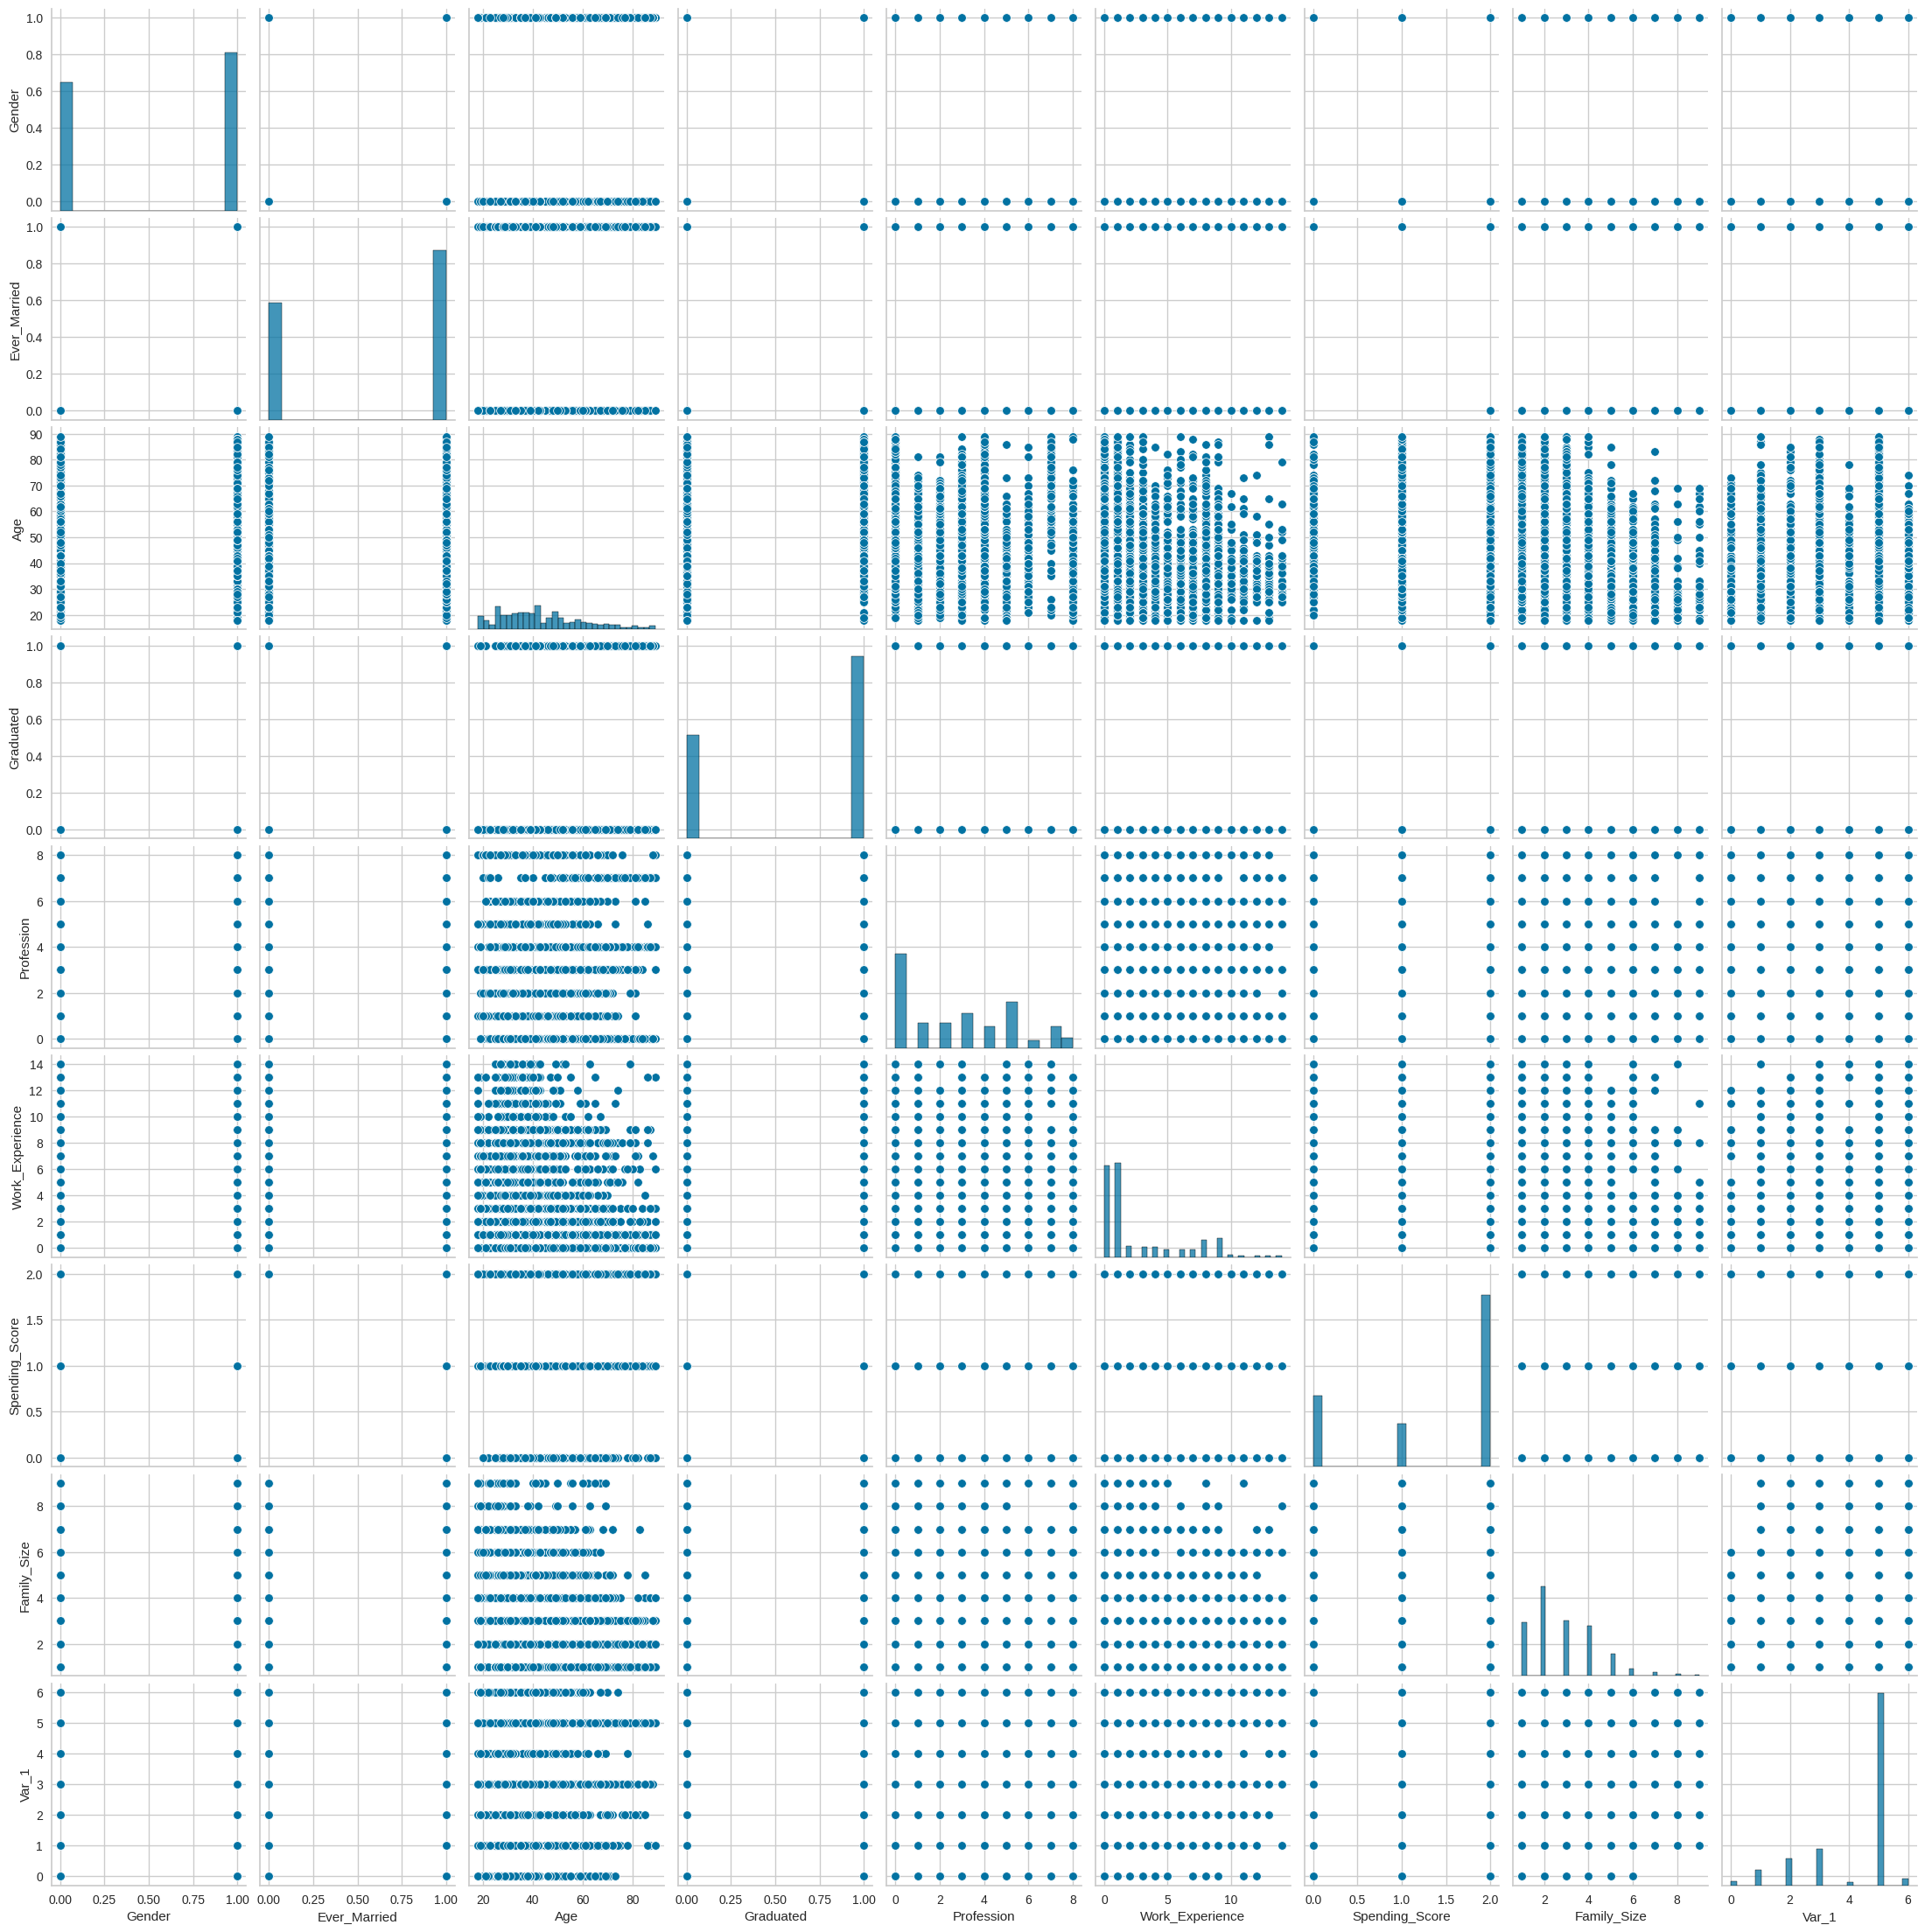

In [ ]:
plt.figure(figsize = (8, 6))
sns.pairplot(data = data_train, palette= "pastel")
plt.show()

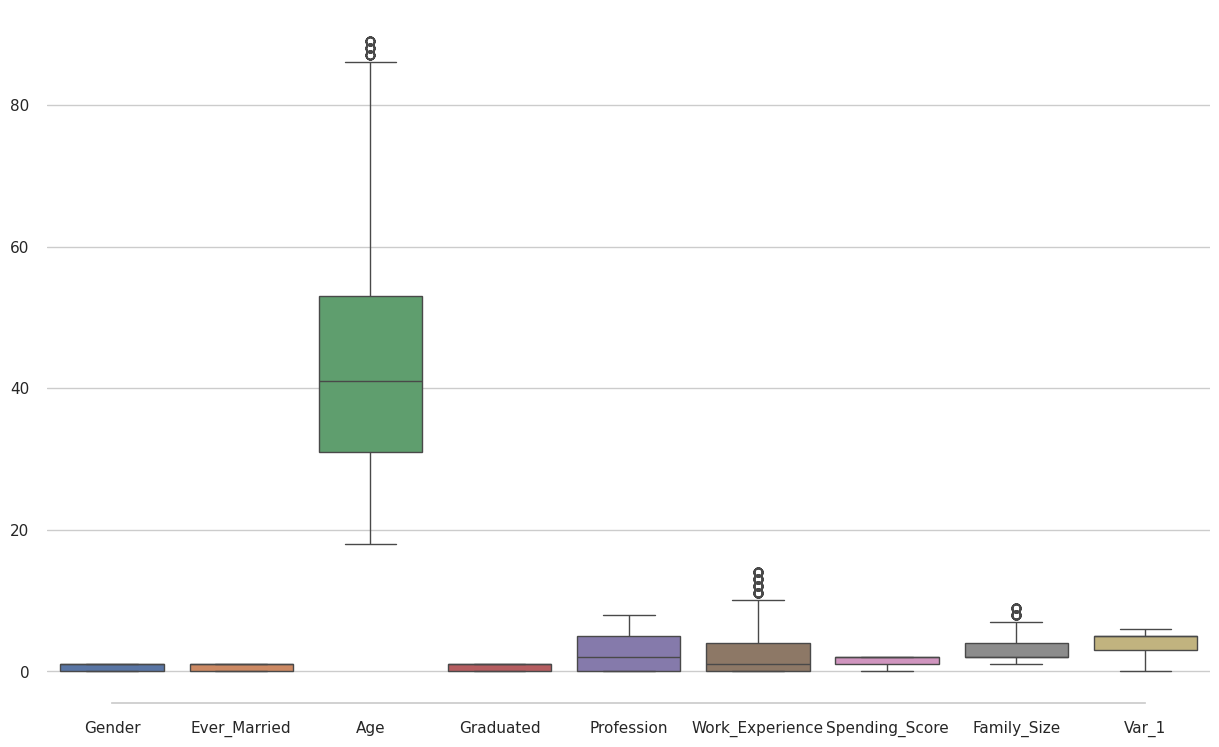

In [ ]:
sns.set(style = "whitegrid")
plt.figure(figsize = (15, 9))
sns.boxplot(data = data_train, showfliers = True)
sns.despine(trim = True, left = True)
plt.show()

In [ ]:
Q1 = data_train[["Age", "Work_Experience", "Family_Size"]].quantile(0.25)
Q2 = data_train[["Age", "Work_Experience", "Family_Size"]].quantile(0.75)

IQR = Q2-Q1
Lower_bound = Q1 - 1.5*IQR
Upper_bound = Q2 + 1.5*IQR

#Removing Outliers from dataset

In [ ]:
Lower_bound

Age               -2.0
Work_Experience   -6.0
Family_Size       -1.0
dtype: float64

In [ ]:
Upper_bound

Age                86.0
Work_Experience    10.0
Family_Size         7.0
dtype: float64

In [ ]:
# data_train.index[data_train["Age"] <= Lower_bound[0]]
#There is only Upper bound outliers
index1 = data_train.index[data_train["Age"] >= Upper_bound[0]]
data_train.drop(index = index1, axis = 0, inplace = True)

index2 = data_train.index[data_train["Work_Experience"] >= Upper_bound[1]]
data_train.drop(index = index2, axis = 0, inplace = True)

index3 = data_train.index[data_train["Family_Size"] >= Upper_bound[2]]
data_train.drop(index = index3, axis = 0, inplace = True)

Checking If outliers Still exist

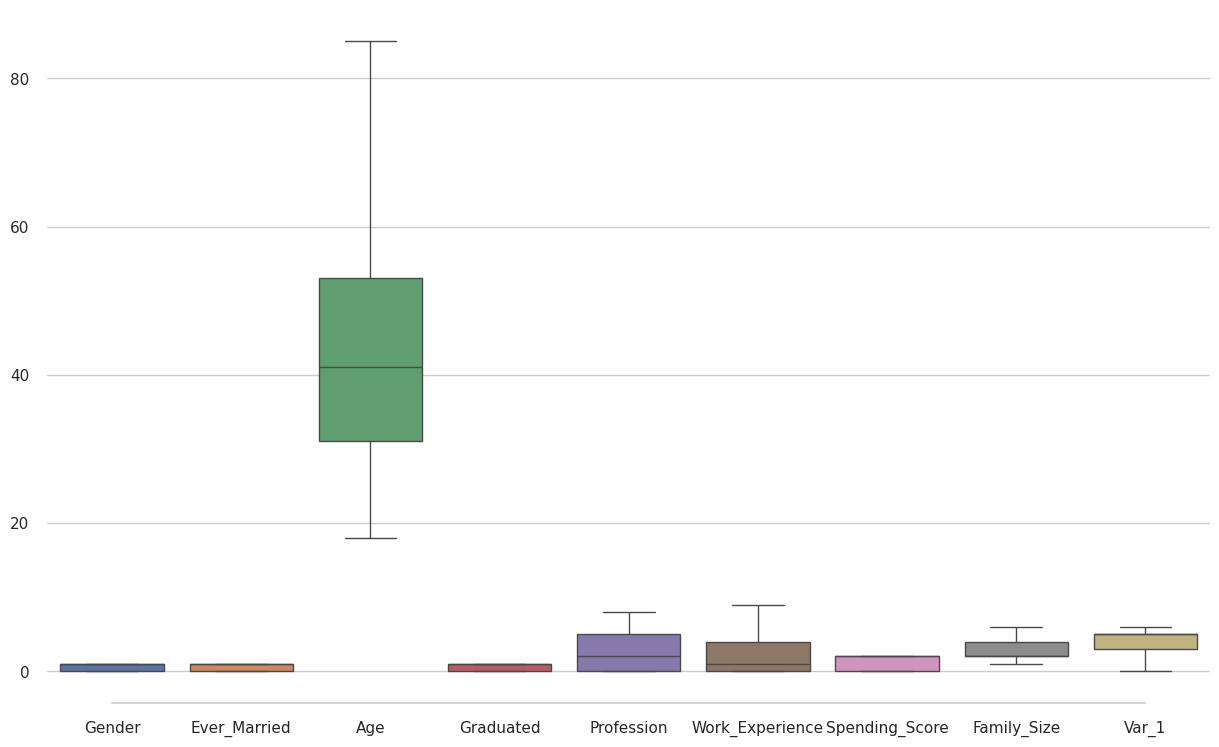

In [ ]:
sns.set(style = "whitegrid")
plt.figure(figsize = (15, 9))
sns.boxplot(data = data_train, showfliers = True)
sns.despine(trim = True, left = True)
plt.show()

As We Can see Outliers are removed

In [ ]:
encoded_column = pd.get_dummies(data_train["Profession"], prefix = "Profession")
encoded_column2 = pd.get_dummies(data_train["Var_1"], prefix = "Var")
Encoded_columns = pd.concat([encoded_column, encoded_column2], axis = 1)

In [ ]:
data_train.drop(["Profession", "Var_1"], axis = 1, inplace = True)
data_train = pd.concat([data_train, Encoded_columns], axis = 1)

In [ ]:
Scaler = MinMaxScaler()
# col_norm = data_train.drop(cat_columns, axis = 1).columns
X_train = Scaler.fit_transform(data_train)

In [ ]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.059701,0.0,0.111111,1.0,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.731343,1.0,0.111111,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.731343,1.0,0.000000,0.5,0.2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.567164,0.0,0.000000,0.0,0.2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.208955,1.0,0.111111,1.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6181,1.0,1.0,0.343284,1.0,0.000000,0.5,0.8,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6182,1.0,0.0,0.253731,0.0,0.333333,1.0,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6183,0.0,0.0,0.223881,1.0,0.111111,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6184,0.0,0.0,0.134328,1.0,0.111111,1.0,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# # Apply PCA
num_components = 9  # Specify the number of components
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(X_train)

Explained Variance Ratio: [0.20115485 0.12481611 0.11079684 0.08880885 0.06664273 0.05201727
 0.04769573 0.04353283 0.04245085]


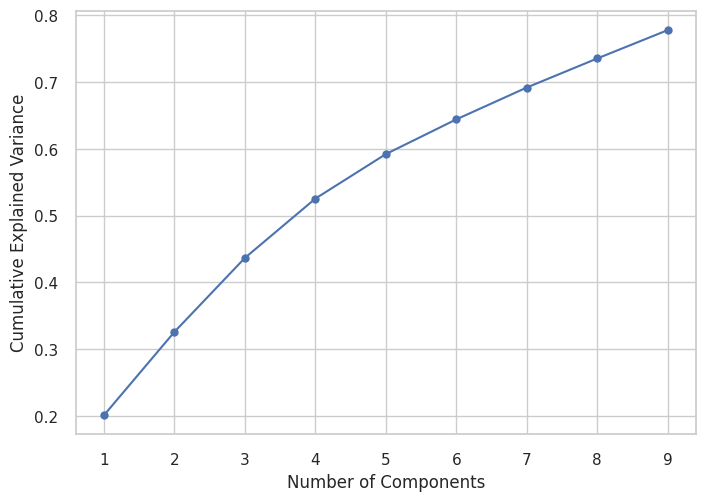

In [ ]:
# # Visualize explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [ ]:
# # Apply PCA
num_components = 3  # Specify the number of components
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(X_train)

Explained Variance Ratio: [0.20115485 0.1248161  0.11079684]


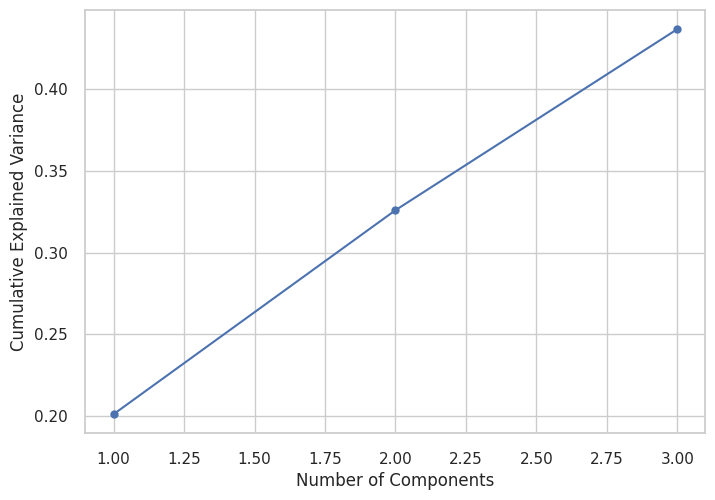

In [ ]:
# # Visualize explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [ ]:
# # Use the reduced data
data_train_red = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, num_components + 1)])
# data_train_red.to_csv("Customer_Segmentation_processed.csv", index =  False)

In [ ]:
data_train_red.head()

,PC1,PC2,PC3
0,1.415949,0.579160,0.040438
1,-0.286909,-0.380359,0.195607
2,-0.610621,0.248334,-0.565762
3,-0.720597,0.386609,-0.295556
4,0.599974,-0.421576,-0.740857


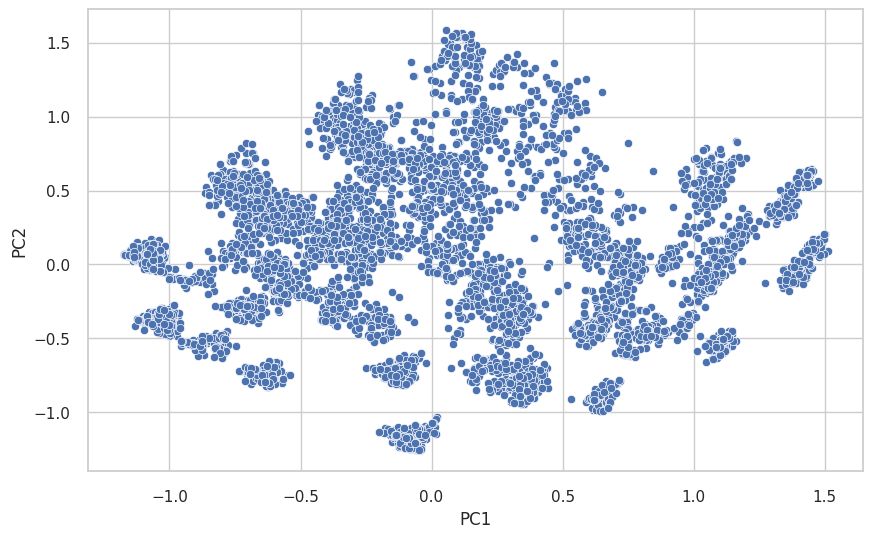

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=data_train_red, x='PC1', y='PC2', ax=ax)

# ax.yaxis.set_visible(False)
# ax.xaxis.set_visible(False)
# ax.spines[:].set_visible(False)

plt.show()

In [ ]:
X_train = np.array(data_train_red)

In [ ]:
data_train_red.head()

,PC1,PC2,PC3
0,1.415949,0.579160,0.040438
1,-0.286909,-0.380359,0.195607
2,-0.610621,0.248334,-0.565762
3,-0.720597,0.386609,-0.295556
4,0.599974,-0.421576,-0.740857


***DBSCAN for clustering***

=>Can Handle Outliers

=>Can Cluster Varying Shapes Unlike Kmeans

=>Can find no of clusters on its own


=> **Disadvantage is As you can see from graph above Density is not uniform for a cluster which is ideal case for DBSCAN and they are too scattered in there own cluster, So DBSCAN with constant epsilon doesn't work that well**


**Using K-Means**

=>Faster than DBSCAN

=>Needs K value unlike DBSCAN

=>Simple Algorithm than DBSCAN

=>Can't Handle non-convex shape

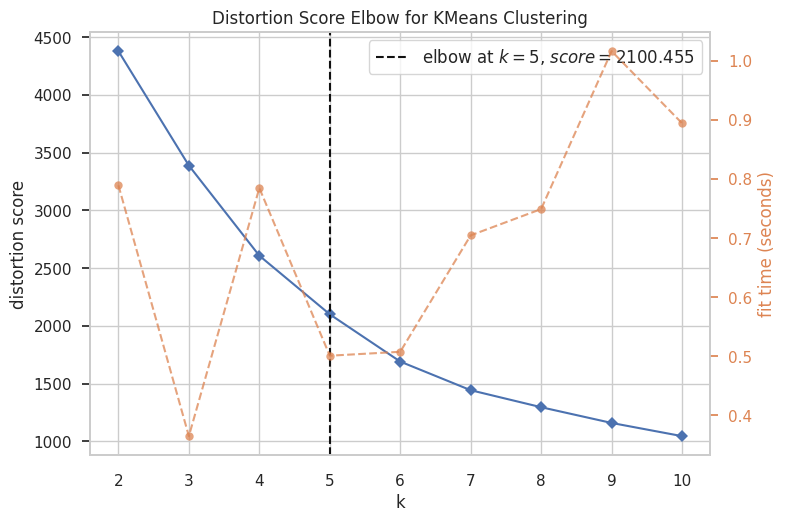

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kelbm = KElbowVisualizer(KMeans(), k = 10)
kelbm.fit(X_train)
kelbm.show()

In [ ]:
k = 3

In [ ]:
kalgo = KMeans(n_clusters = k, n_init= "auto", random_state= 42)
his = kalgo.fit(X_train)

In [ ]:
his.cluster_centers_

array([[ 0.81224385, -0.16011433, -0.05668581],
       [-0.57829441, -0.33940151,  0.19693805],
       [-0.24176073,  0.56852707, -0.16300809]])

In [ ]:
labels = kalgo.labels_

In [ ]:
mapping = {0:"A", 1:"B", 2:"C", 3:"D", 4:"E"}
labels_mapping = [mapping[label] for label in labels if label is not None]
data_train_red = pd.concat([data_train_red, pd.DataFrame({"Clusters":labels_mapping})], axis = 1)

In [ ]:
data_train_red.head()

,PC1,PC2,PC3,Clusters
0,1.415949,0.579160,0.040438,A
1,-0.286909,-0.380359,0.195607,B
2,-0.610621,0.248334,-0.565762,C
3,-0.720597,0.386609,-0.295556,C
4,0.599974,-0.421576,-0.740857,A


<Axes: xlabel='PC1', ylabel='PC2'>

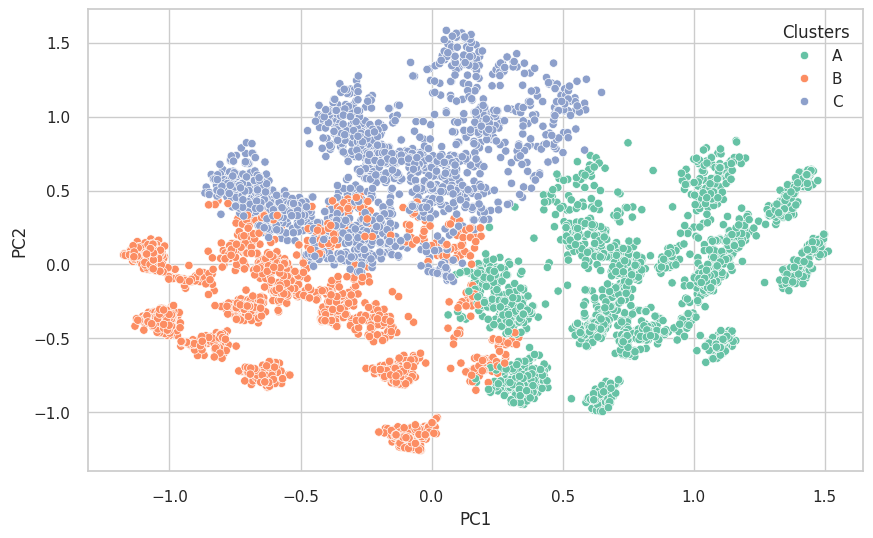

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.scatterplot(data = data_train_red, x = "PC1", y= "PC2", hue = "Clusters" ,ax = ax, palette = "Set2")

In [ ]:
palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
colors = {"A":"#D6B2B1" , "B":"#9E726F" , "C": "#F3AB60" ,"D":"#682F2F"}

In [ ]:
colors_seq = [colors.get(cluster)  for cluster in labels_mapping]

In [ ]:
# Scatter plot using Matplotlib directly
# Create a 3D scatter plot
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
scatter = px.scatter_3d(data_train_red, data_train_red['PC3'], data_train_red['PC2'], data_train_red['PC1'], color=data_train_red["Clusters"],opacity = 0.9, color_continuous_scale='viridis')

# Show the plot
scatter.show()

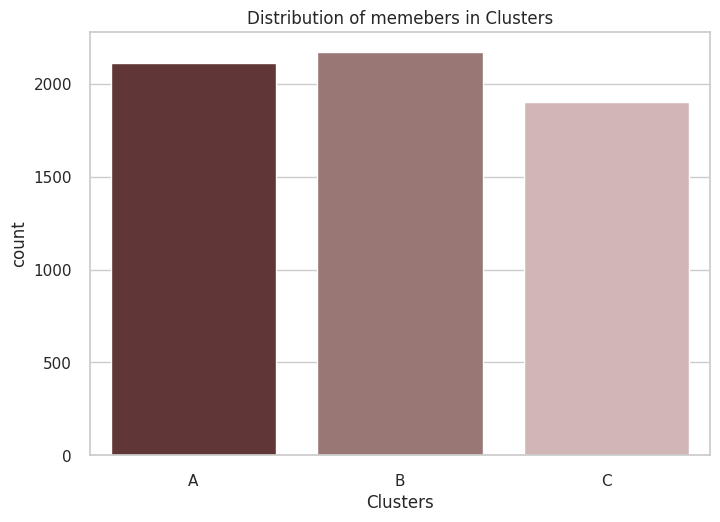

In [ ]:
dis_graph = sns.countplot(x = data_train_red["Clusters"], palette = palette[:4])
dis_graph.set_title("Distribution of memebers in Clusters")
plt.show()

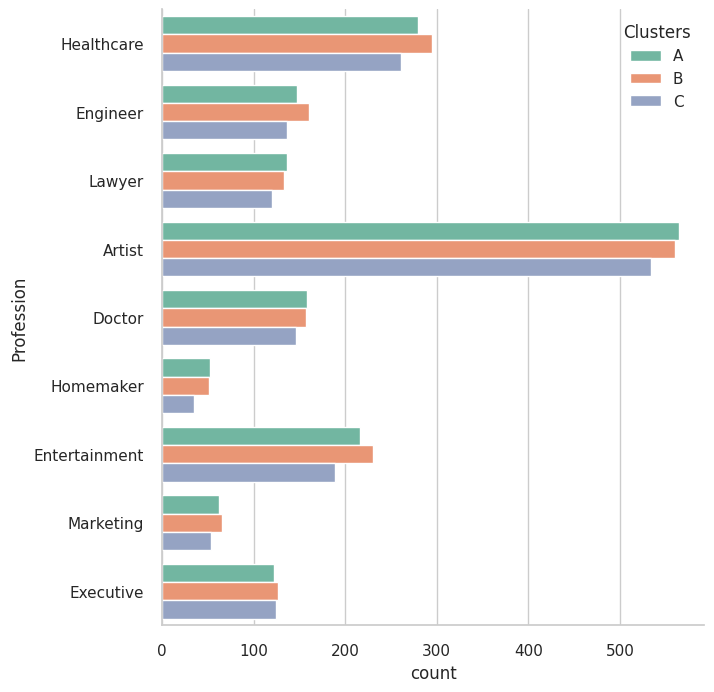

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))

sns.countplot(profession_df, y='Profession', hue= data_train_red["Clusters"], palette='Set2')

ax.spines[['top', 'right']].set_visible(False)

plt.show()

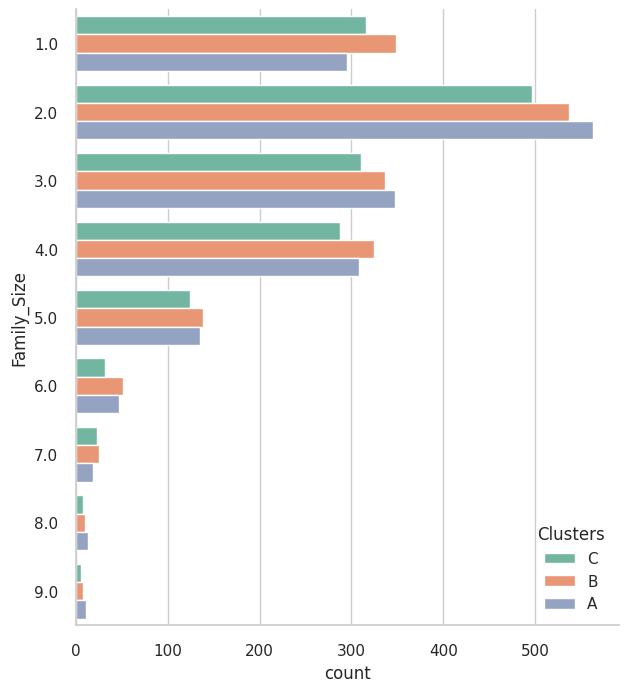

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))

sns.countplot(family_df, y='Family_Size', hue= data_train_red["Clusters"], palette='Set2')

ax.spines[['top', 'right']].set_visible(False)

plt.show()

##  Three clusters are present in Customer Population (A, B, C)

##There are Many Artist in Customer Population most in Cluseter A

##Most of the Clusters have 2 Family_size

##Three Dominating Professions are =>
##1)Artists
##2)HealthCare
##3)Entertainment